In [1]:
from dataset import Dataset
from entropy import Entropy
from probability import *
from word_counter import WordCounter
from scrambler import *
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from n_gram import NGramModel
import pandas
from IPython.display import Latex

In [2]:
def get_vocabulary(dataset: Dataset) -> list:
        vocabulary = set()
        for word in dataset:
            vocabulary.add(word)

        return list(vocabulary)

In [3]:
def display_coefficients(model: NGramModel):
    for i in range(len(model.lambdas)):
        display(Latex(fr"$\lambda_{i} = {model.lambdas[i]}$"))

In [4]:
TEXT_FILE1 = "TEXTEN1.txt"
TEXT_FILE2 = "TEXTCZ1.txt"

dataset1 = Dataset()
dataset1.from_file(TEXT_FILE1, 0)

dataset2 = Dataset()
dataset2.from_file(TEXT_FILE2, 0)

In [5]:
dataset1_train = Dataset()
dataset2_train = Dataset()

dataset1_heldout = Dataset()
dataset2_heldout = Dataset()

dataset1_test = Dataset()
dataset2_test = Dataset()

dataset1_train.from_list(dataset1[:len(dataset1) - 60_000], 2)
dataset2_train.from_list(dataset2[:len(dataset2) - 60_000], 2)

dataset1_heldout.from_list(dataset1[len(dataset1) - 60_000: len(dataset1) - 20_000], 2)
dataset2_heldout.from_list(dataset2[len(dataset2) - 60_000: len(dataset2) - 20_000], 2)

dataset1_test.from_list(dataset1[-20_000:], 2)
dataset2_test.from_list(dataset2[-20_000:], 2)

tmp_dataset1 = Dataset()
tmp_dataset2 = Dataset()

tmp_dataset1.from_list(dataset1[:len(dataset1) - 20_000]) # train + heldout
tmp_dataset2.from_list(dataset2[:len(dataset2) - 20_000]) # train + heldout

vocabulary1 = get_vocabulary(tmp_dataset1)
vocabulary2 = get_vocabulary(tmp_dataset2)

# Train the model on train data and compute the coefficients on train data

In [6]:
model1 = NGramModel(3)
model2 = NGramModel(3)

In [7]:
model1.fit(dataset1_train, dataset1_train, vocabulary1, 0.00001)
model2.fit(dataset2_train, dataset2_train, vocabulary2, 0.00001)

Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Training iteration 5
Training iteration 6
Training iteration 7
Training iteration 8
Training iteration 9
Training iteration 10
Training iteration 11
Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Training iteration 5
Training iteration 6
Training iteration 7
Training iteration 8
Training iteration 9
Training iteration 10
Training iteration 11


In [8]:
print(f"The model coefficients for {TEXT_FILE1} are:")
display_coefficients(model1)

The model coefficients for TEXTEN1.txt are:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
print(f"The model coefficients for {TEXT_FILE2} are:")
display_coefficients(model2)

The model coefficients for TEXTCZ1.txt are:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In both models the value of lambda_3 is close to 1 because when we compute the conditional probabilities on train data and compute the lambdas
on train data as well, the algorithm is going to prefer the conditional probability of trigrams because they are the most accurate on the
training dataset. Therefore, we need to train the lambdas on heldout data.

# Train the model on train data and compute the coefficients on held out data

In [10]:
model1 = NGramModel(3)
model2 = NGramModel(3)

In [11]:
model1.fit(dataset1_train, dataset1_heldout, vocabulary1, 0.00001)
model2.fit(dataset2_train, dataset2_heldout, vocabulary2, 0.00001)

Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Training iteration 5
Training iteration 6
Training iteration 7
Training iteration 8
Training iteration 9
Training iteration 10
Training iteration 11
Training iteration 12
Training iteration 13
Training iteration 14
Training iteration 15
Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Training iteration 5
Training iteration 6
Training iteration 7
Training iteration 8
Training iteration 9
Training iteration 10
Training iteration 11
Training iteration 12
Training iteration 13
Training iteration 14
Training iteration 15
Training iteration 16
Training iteration 17


In [12]:
pandas.DataFrame(np.array([model1.lambdas, model2.lambdas]).T, index=["lambda_0", "lambda_1", "lambda_2", "lambda_3"], columns=[TEXT_FILE1, TEXT_FILE2])

,TEXTEN1.txt,TEXTCZ1.txt
lambda_0,0.065985,0.132381
lambda_1,0.259773,0.440412
lambda_2,0.491912,0.243891
lambda_3,0.182330,0.183316


The coefficients after training on heldout data seem to prefer bigrams for TEXTEN1.txt and unigrams for TEXTCZ1.txt From the dataset analysis we know, that the vocabulary of the Czech text is much greater than the vocabulary of English text. At the same time, the proportion of words that appear in the text only once is much greater for the Czech text than the English text. Therefore, these words will be modelled by unigram model and that is the reason why it is being favoured in the Czech model. On the other hand, as the vocabulary for English text is smaller and there is smaller proportion of words that have low frequence a bigram model is favoured because it focuses more on the context.

# Coverage graph

In [13]:
dataset1_test_vocabulary = get_vocabulary(dataset1_test)
dataset1_train_vocabulary = get_vocabulary(dataset1_train)

dataset2_test_vocabulary = get_vocabulary(dataset2_test)
dataset2_train_vocabulary = get_vocabulary(dataset2_train)

In [14]:
dataset1_word_present_sum = 0
for word in dataset1_test_vocabulary:
    if word in dataset1_train_vocabulary:
        dataset1_word_present_sum += 1

dataset2_word_present_sum = 0
for word in dataset2_test_vocabulary:
    if word in dataset2_train_vocabulary:
        dataset2_word_present_sum += 1

In [15]:
pandas.DataFrame([dataset1_word_present_sum / len(dataset1_train_vocabulary), dataset2_word_present_sum / len(dataset2_train_vocabulary)], index=[TEXT_FILE1, TEXT_FILE2], columns=["Coverage of test vocabulary in train vocabulary"])

,Coverage of test vocabulary in train vocabulary
TEXTEN1.txt,0.296645
TEXTCZ1.txt,0.131741


# Compute cross entropy of the test data

In [16]:
pandas.DataFrame([Entropy.compute_entropy(model1, dataset1_test), Entropy.compute_entropy(model2, dataset2_test)], index=[TEXT_FILE1, TEXT_FILE2], columns=["entropy"])

,entropy
TEXTEN1.txt,10.138901
TEXTCZ1.txt,11.841228


We observe higher entropy on TEXTCZ1.txt file which makes sense because the data is much more diverse than the English data file and therefore it is harder to model. Also, more of the training vocabulary is in the test set for English but for Czech there is significantly less test vocabulary in train vocabulary.

# Increasing the trigram coefficient

In [17]:
initial_lambdas1 = model1.lambdas[:]
initial_lambdas2 = model2.lambdas[:]

In [18]:
proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
results1 = [Entropy.compute_entropy(model1, dataset1_test)]
results2 = [Entropy.compute_entropy(model2, dataset2_test)]
for proportion in proportions:
    model1.increase_lambda(3, proportion)
    model2.increase_lambda(3, proportion)

    results1.append(Entropy.compute_entropy(model1, dataset1_test))
    results2.append(Entropy.compute_entropy(model2, dataset2_test))

    model1.lambdas = initial_lambdas1[:]
    model2.lambdas = initial_lambdas2[:]

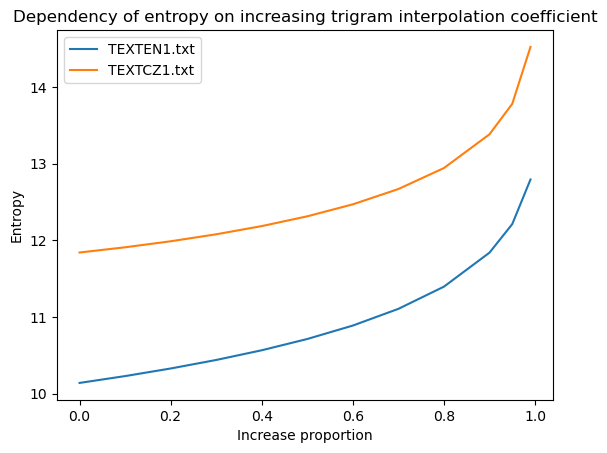

In [19]:
plt.plot([0] + proportions, results1)
plt.plot([0] + proportions, results2)
plt.xlabel("Increase proportion")
plt.ylabel("Entropy")
plt.title("Dependency of entropy on increasing trigram interpolation coefficient")
plt.legend([TEXT_FILE1, TEXT_FILE2])

In [20]:
proportions = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
results1 = [Entropy.compute_entropy(model1, dataset1_test)]
results2 = [Entropy.compute_entropy(model2, dataset2_test)]
for proportion in proportions:
    model1.decrease_lambda(3, proportion)
    model2.decrease_lambda(3, proportion)

    results1.append(Entropy.compute_entropy(model1, dataset1_test))
    results2.append(Entropy.compute_entropy(model2, dataset2_test))

    model1.lambdas = initial_lambdas1[:]
    model2.lambdas = initial_lambdas2[:]

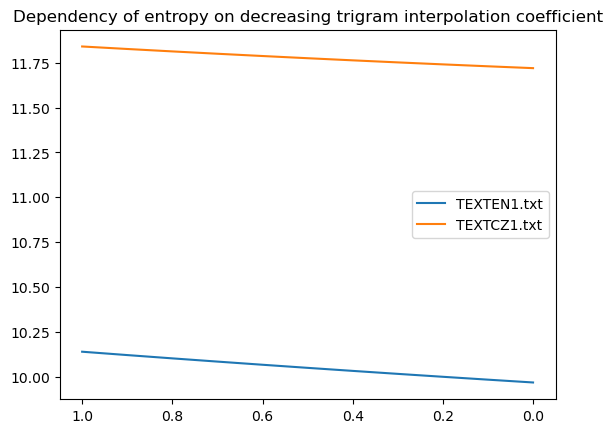

In [21]:
plt.plot([1.0] + proportions, results1)
plt.plot([1.0] + proportions, results2)
plt.gca().invert_xaxis()
plt.title("Dependency of entropy on decreasing trigram interpolation coefficient")
plt.legend([TEXT_FILE1, TEXT_FILE2])

The entropy increases with increasing the interpolation coefficient in n-gram model because the trigram part of the model has very long history and thus cannot generalize much on the learned data. On the other hand, decreasing the interpolation coefficient for trigram decreases the entropy, because it allows the other more general n-grams to perform the prediction. The entropy of the Czech text is higher than for the English text because there is less overlap between the training and testing vocabulary.